In [1]:
import os
from PIL import Image
import numpy as np

In [2]:
def load_caltech20_dataset(dataset_path):
    """
    Loads the Caltech20 dataset from the specified directory.

    Parameters:
    dataset_path (str): The path to the dataset directory. The directory should contain subdirectories,
                        each representing a class, with images inside.

    Returns:
    tuple: A tuple containing:
        - image_paths (list): A list of file paths to the images.
        - labels (numpy.ndarray): An array of integer labels corresponding to the classes of the images.
        - classes (list): A sorted list of class names (subdirectory names).
    """
    image_paths, labels = [], []
    classes = sorted(os.listdir(dataset_path))

    for label, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                image_paths.append(img_path)
                labels.append(label)

    return image_paths, np.array(labels), classes


In [8]:
image_paths, y, class_names = load_caltech20_dataset("caltech20")

print(f"Nombre d'images : {len(image_paths)}")
print(f"Nombre de classes : {len(class_names)}")
print(f"Exemples de classes : {class_names[:5]}")


Nombre d'images : 1051
Nombre de classes : 20
Exemples de classes : ['ant', 'beaver', 'brontosaurus', 'cannon', 'chair']


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_paths, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 840
Testing set size: 211


In [15]:
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def load_image(image_path):
    """
    Loads an image from the specified path and converts it to RGB format.

    Parameters:
    image_path (str): The path to the image file.

    Returns:
    numpy.ndarray: The loaded image in RGB format.
    """
    img = Image.open(image_path)
    img = img.convert("RGB")
    return np.array(img)

def extract_sift_features_from_images(images):
    sift = cv2.SIFT_create()
    all_descriptors = []
    for img in images:
        img = load_image(img)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        _, descriptors = sift.detectAndCompute(gray, None)
        if descriptors is not None:
            all_descriptors.append(descriptors)
    return all_descriptors

def sample_descriptors(descriptor_list, max_samples=10000):
    all_desc = np.vstack(descriptor_list)
    idx = np.random.choice(len(all_desc), min(max_samples, len(all_desc)), replace=False)
    return all_desc[idx]

def reduce_dimensionality(descriptors, n_components=64):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(descriptors), pca

def build_codebook(descriptors, k=100):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(descriptors)
    return kmeans

def compute_bow_histogram(img, sift, pca, kmeans):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is None:
        return np.zeros(kmeans.n_clusters)
    descriptors = pca.transform(descriptors)
    labels = kmeans.predict(descriptors)
    hist, _ = np.histogram(labels, bins=np.arange(kmeans.n_clusters + 1))
    return hist / np.linalg.norm(hist)

def encode_bow_features(images, sift, pca, kmeans):
    return np.array([compute_bow_histogram(load_image(img), sift, pca, kmeans) for img in images])


In [16]:
sift = cv2.SIFT_create()
descs = extract_sift_features_from_images(X_train)
sampled = sample_descriptors(descs)
reduced, pca = reduce_dimensionality(sampled)
kmeans = build_codebook(reduced)

X_train_bow = encode_bow_features(X_train, sift, pca, kmeans)
X_test_bow = encode_bow_features(X_train, sift, pca, kmeans)



In [20]:
import matplotlib.pyplot as plt

def plot_bow_histogram(hist, class_name=None):
    plt.figure(figsize=(8, 4))
    plt.bar(np.arange(len(hist)), hist)
    plt.title(f'BoW Histogram {f"({class_name})" if class_name else ""}')
    plt.xlabel('Visual Word Index')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

def show_sift_keypoints(img):
    sift = cv2.SIFT_create()
    img = load_image(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    keypoints = sift.detect(gray, None)
    img_kp = cv2.drawKeypoints(img, keypoints, None,
                               flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_kp)
    plt.axis('off')
    plt.title("SIFT Keypoints")
    plt.show()


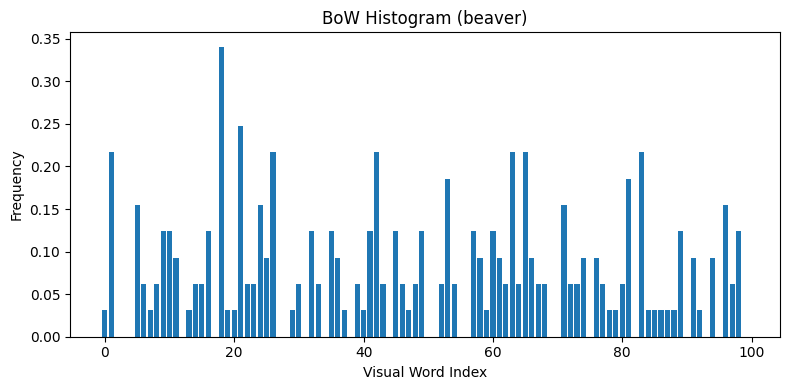

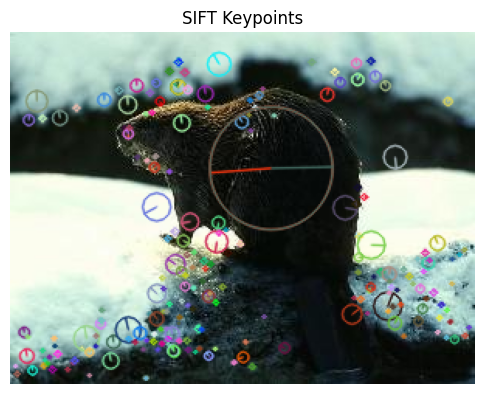

In [21]:
# Histogramme BoW
hist = X_train_bow[19]
plot_bow_histogram(hist, class_name=class_names[y_train[19]])

# Visualiser les SIFT
show_sift_keypoints(X_train[19])


In [ ]:
def compute_spatial_pyramid_bow(img, sift, pca, kmeans, levels=[1, 2]):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is None:
        return np.zeros(kmeans.n_clusters * sum(l**2 for l in levels))

    descriptors = pca.transform(descriptors)
    h, w = img.shape[:2]
    coords = np.array([kp.pt for kp in keypoints])  # (x, y)

    pyramid_features = []

    for level in levels:
        step_x = w / level
        step_y = h / level

        for i in range(level):
            for j in range(level):
                xmin, xmax = i * step_x, (i + 1) * step_x
                ymin, ymax = j * step_y, (j + 1) * step_y

                # Filtrer les points-clés dans la cellule
                mask = ((coords[:, 0] >= xmin) & (coords[:, 0] < xmax) &
                        (coords[:, 1] >= ymin) & (coords[:, 1] < ymax))

                if np.any(mask):
                    desc_cell = descriptors[mask]
                    labels = kmeans.predict(desc_cell)
                    hist, _ = np.histogram(labels, bins=np.arange(kmeans.n_clusters + 1))
                else:
                    hist = np.zeros(kmeans.n_clusters)

                pyramid_features.append(hist)

    final = np.concatenate(pyramid_features).astype(np.float32)
    return final / np.linalg.norm(final)

def encode_spatial_pyramid_features(images, sift, pca, kmeans, levels=[1, 2]):
    return np.array([compute_spatial_pyramid_bow(img, sift, pca, kmeans, levels) for img in images])


import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_spatial_pyramid_grid(img, levels=[1, 2]):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img)
    h, w = img.shape[:2]

    for level in levels:
        step_x = w / level
        step_y = h / level
        for i in range(level):
            for j in range(level):
                rect = patches.Rectangle((i*step_x, j*step_y), step_x, step_y,
                                         linewidth=1.5, edgecolor='red', facecolor='none')
                ax.add_patch(rect)

    ax.set_title(f"Spatial Pyramid Grid: levels={levels}")
    ax.axis('off')
    plt.show()



In [ ]:
# 1. Afficher les cellules sur une image
draw_spatial_pyramid_grid(X_train[0], levels=[1, 2])

# 2. Encoder avec BoW pyramidal
X_train_pyr = encode_spatial_pyramid_features(X_train, sift, pca, kmeans, levels=[1, 2])
X_test_pyr = encode_spatial_pyramid_features(X_test, sift, pca, kmeans, levels=[1, 2])

# 3. Afficher un histogramme pyramidal
plot_bow_histogram(X_train_pyr[0], class_name=class_names[y_train[0]])
